## Grafica Comparacion Modelos

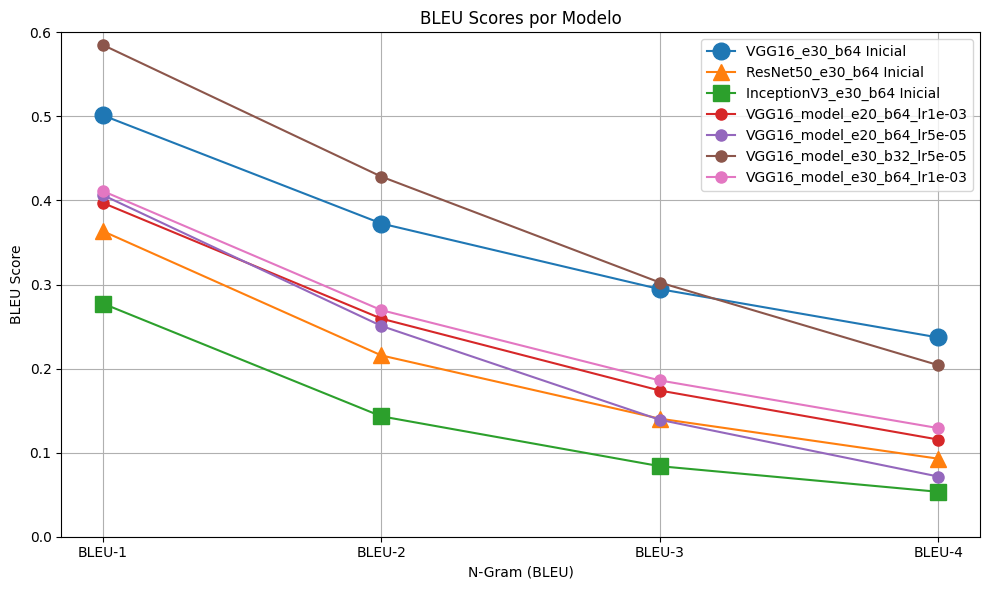

In [1]:
import matplotlib.pyplot as plt

# Datos de BLEU Scores por modelo
bleu_scores = {
    "VGG16_e30_b64 Inicial": [0.501170, 0.372547, 0.294499, 0.237009],
    "ResNet50_e30_b64 Inicial": [0.363395, 0.215636, 0.140402, 0.092832],
    "InceptionV3_e30_b64 Inicial": [0.277302, 0.143201, 0.083901, 0.053432],
    "VGG16_model_e20_b64_lr1e-03": [0.3970, 0.2594, 0.1739, 0.1156],
    "VGG16_model_e20_b64_lr5e-05": [0.4063, 0.2507, 0.1391, 0.0716],
    "VGG16_model_e30_b32_lr5e-05": [0.5849, 0.4283, 0.3024, 0.2041],
    "VGG16_model_e30_b64_lr1e-03" : [0.4111,0.2695,0.1859,0.1292] 
}

bleu_levels = ["BLEU-1", "BLEU-2", "BLEU-3", "BLEU-4"]

# Crear la gráfica
plt.figure(figsize=(10, 6))

for model, scores in bleu_scores.items():
    if "ResNet" in model:
        marker = '^'  # Triángulo
    elif "Inception" in model:
        marker = 's'  # Cuadrado
    elif "VGG" in model:
        marker = 'o'  # Círculo
    else:
        marker = 'x'  # Marcador por defecto

    # Tamaño del marcador
    size = 12 if "Inicial" in model else 8

    plt.plot(bleu_levels, scores, marker=marker, label=model, markersize=size)

plt.title("BLEU Scores por Modelo")
plt.xlabel("N-Gram (BLEU)")
plt.ylabel("BLEU Score")
plt.ylim(0, 0.6)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Funciones Necesarias

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, add
from tensorflow.keras.applications.vgg16 import preprocess_input
import pickle

with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

# Cargar features
with open("features.pkl", "rb") as f:
    features = pickle.load(f)

# Cargar descripciones
with open("descriptions.pkl", "rb") as f:
    descriptions = pickle.load(f)

vocab_size = len(tokenizer.word_index) + 1

def max_length(descriptions):
    return max(len(d.split()) for desc in descriptions.values() for d in desc)


max_len = max_length(descriptions)
print("Vocab size:", vocab_size)
print("Max caption length:", max_len)


from tensorflow.keras.utils import pad_sequences, to_categorical
import numpy as np

def data_generator(descriptions, features, tokenizer, max_len, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                seq = tokenizer.texts_to_sequences([desc])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_len)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(features[key])
                    X2.append(in_seq)
                    y.append(out_seq)

                    n += 1
                    if n == batch_size:
                        yield ([np.array(X1), np.array(X2)], np.array(y))
                        X1, X2, y = [], [], []
                        n = 0


from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

def generate_caption(model, tokenizer, photo, max_len):
    in_text = 'startseq'
    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text.replace('startseq ', '').replace(' endseq', '')

import os
import matplotlib.pyplot as plt
from PIL import Image

def show_prediction(image_name, models, model_names, tokenizer, features, descriptions, max_length, base_dir="Images"):
    # Obtener ID de imagen sin .jpg
    image_id = image_name.split('.')[0]
    
    # Ruta a la imagen
    img_path = os.path.join(base_dir, image_name)
    
    # Abrir imagen
    image = Image.open(img_path)

    # Mostrar captions reales
    print("\n------------------ Actual Captions ------------------")
    for caption in descriptions[image_id]:
        print(caption)

    # Obtener las features de la imagen
    photo = features[image_id].reshape((1, 4096))
    
    # Mostrar imagen
    plt.imshow(image)
    plt.axis('off')
    plt.title("Prededcir Imagen", fontsize=12)
    plt.show()

    # Predecir y mostrar los captions de cada modelo
    print("\n------------------ Predicted Captions ------------------")
    for model, name in zip(models, model_names):
        y_pred = generate_caption(model, tokenizer, photo, max_length)
        print(f"{name}: {y_pred}\n")


def generate_caption_with_probs(model, tokenizer, photo, max_len, top_k=5):
    in_text = 'startseq'
    results = []

    for _ in range(max_len):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_len)

        yhat = model.predict([photo, sequence], verbose=0)[0]  # Shape: (vocab_size,)
        
        # Obtener índice de palabra con mayor probabilidad
        yhat_idx = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_idx)

        # Obtener top-k palabras con más probabilidad (opcional)
        top_indices = np.argsort(yhat)[-top_k:][::-1]
        top_words = [(tokenizer.index_word.get(i, ""), float(yhat[i])) for i in top_indices]

        # Guardar palabra generada y sus top-k probabilidades
        results.append({
            "word": word,
            "top_k_probs": top_words
        })

        if word is None:
            break

        in_text += ' ' + word

        if word == 'endseq':
            break

    caption = in_text.replace('startseq ', '').replace(' endseq', '')
    return caption, results

def show_prediction_with_probs(image_name, models, model_names, tokenizer, features, descriptions, max_length, base_dir="Images", top_k=3):
    # Obtener ID de imagen sin .jpg
    image_id = image_name.split('.')[0]

    # Ruta a la imagen
    img_path = os.path.join(base_dir, image_name)

    # Abrir imagen
    image = Image.open(img_path)

    # Mostrar captions reales
    print("\n------------------ Actual Captions ------------------")
    for caption in descriptions[image_id]:
        print("•", caption)

    # Obtener las features de la imagen
    photo = features[image_id].reshape((1, 4096))

    # Mostrar imagen
    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicción por modelos", fontsize=12)
    plt.show()

    # Predecir y mostrar los captions y probabilidades
    print("\n------------------ Predicted Captions with Probabilities ------------------")
    for model, name in zip(models, model_names):
        caption, steps = generate_caption_with_probs(model, tokenizer, photo, max_length, top_k=top_k)
        print(f"\n🧠 Modelo: {name}")
        print(f"📝 Caption: {caption}\n")
        for i, step in enumerate(steps):
            print(f"Paso {i+1}: '{step['word']}'")
            for w, p in step['top_k_probs']:
                print(f"   - {w:<15} Prob: {p:.4f}")
        print("-" * 50)

Vocab size: 8574
Max caption length: 34


## Modelos

In [3]:
from tensorflow.keras.models import load_model

# Cargar el modelo desde el archivo
model_video = load_model("caption_model_video.h5")

model_e30_b64_lr1e_03=load_model("caption_model_e30_b64_lr1e-03.h5")

model_e30_b32_lr1e_03=load_model("caption_model_e30_b32_lr1e-03.h5")

model_e30_b64_lr5e_05=load_model("caption_model_e20_b64_lr5e-05.h5")

resnet50_model=load_model("caption_model_resnet50.h5")

inception_model=load_model("caption_model_inceptionV3.h5")


In [4]:
models = [
    model_video,                      # VGG16_e30_b64 Inicial
    model_e30_b64_lr1e_03,           # VGG16_model_e30_b64_lr1e-03
    model_e30_b32_lr1e_03,           # VGG16_model_e30_b32_lr5e-05 (si decides usarlo)
    model_e30_b64_lr5e_05            # VGG16_model_e20_b64_lr5e-05
]


model_names = [
    "VGG16_e30_b64 Inicial",
    "VGG16_model_e30_b64_lr1e-03",
    "VGG16_model_e30_b32_lr5e-05",
    "VGG16_model_e20_b64_lr5e-05"
]


## Predicciones


------------------ Actual Captions ------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq


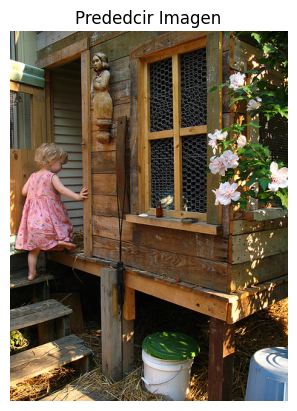


------------------ Predicted Captions ------------------
VGG16_e30_b64 Inicial: child in pink dress is standing in an entry earphones

VGG16_model_e30_b64_lr1e-03: little girl in pink dress climbing

VGG16_model_e30_b32_lr5e-05: man in pink outfit and red shirt stands in front of skyscraper

VGG16_model_e20_b64_lr5e-05: little girl is climbing in wooden wooden wooden



In [5]:
show_prediction(
    image_name="1000268201_693b08cb0e.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images"
)


------------------ Actual Captions ------------------
• startseq child in pink dress is climbing up set of stairs in an entry way endseq
• startseq girl going into wooden building endseq
• startseq little girl climbing into wooden playhouse endseq
• startseq little girl climbing the stairs to her playhouse endseq
• startseq little girl in pink dress going into wooden cabin endseq


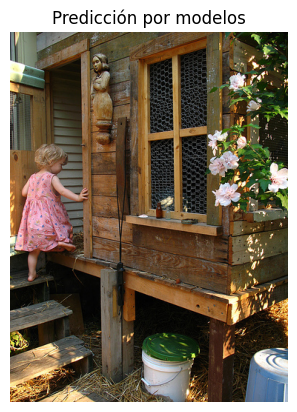


------------------ Predicted Captions with Probabilities ------------------

🧠 Modelo: VGG16_e30_b64 Inicial
📝 Caption: child in pink dress is standing in an entry earphones

Paso 1: 'child'
   - child           Prob: 0.2089
   - little          Prob: 0.1333
   - woman           Prob: 0.1294
Paso 2: 'in'
   - in              Prob: 0.6373
   - is              Prob: 0.1360
   - with            Prob: 0.0847
Paso 3: 'pink'
   - pink            Prob: 0.4627
   - yellow          Prob: 0.4401
   - boat            Prob: 0.0507
Paso 4: 'dress'
   - dress           Prob: 0.9740
   - shirt           Prob: 0.0137
   - is              Prob: 0.0027
Paso 5: 'is'
   - is              Prob: 0.5862
   - going           Prob: 0.1555
   - overlooking     Prob: 0.0783
Paso 6: 'standing'
   - standing        Prob: 0.3167
   - playing         Prob: 0.1999
   - climbing        Prob: 0.1528
Paso 7: 'in'
   - in              Prob: 0.4815
   - on              Prob: 0.3527
   - at              Prob: 0.1262
Paso 

In [6]:
show_prediction_with_probs(
    image_name="1000268201_693b08cb0e.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images",
    top_k=3  # Cambia a 5 si quieres ver top-5
)


------------------ Actual Captions ------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tricolored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq


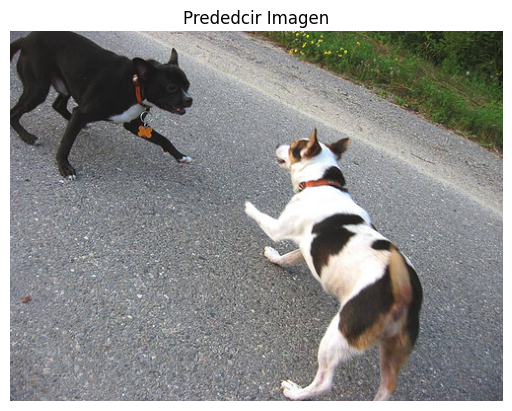


------------------ Predicted Captions ------------------
VGG16_e30_b64 Inicial: black dog and black dog with black spots are fighting

VGG16_model_e30_b64_lr1e-03: black dog and black dog are looking at each road

VGG16_model_e30_b32_lr5e-05: dog is running through the air to catch frisbee

VGG16_model_e20_b64_lr5e-05: two dog are each each other other other other



In [7]:
show_prediction(
    image_name="1001773457_577c3a7d70.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images"
)


------------------ Actual Captions ------------------
• startseq black dog and spotted dog are fighting endseq
• startseq black dog and tricolored dog playing with each other on the road endseq
• startseq black dog and white dog with brown spots are staring at each other in the street endseq
• startseq two dogs of different breeds looking at each other on the road endseq
• startseq two dogs on pavement moving toward each other endseq


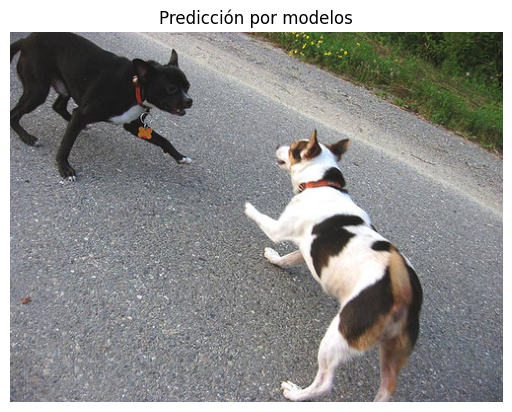


------------------ Predicted Captions with Probabilities ------------------

🧠 Modelo: VGG16_e30_b64 Inicial
📝 Caption: black dog and black dog with black spots are fighting

Paso 1: 'black'
   - black           Prob: 0.5650
   - two             Prob: 0.3456
   - the             Prob: 0.0611
Paso 2: 'dog'
   - dog             Prob: 0.9596
   - and             Prob: 0.0365
   - dogs            Prob: 0.0039
Paso 3: 'and'
   - and             Prob: 0.9638
   - with            Prob: 0.0109
   - are             Prob: 0.0090
Paso 4: 'black'
   - black           Prob: 0.4546
   - white           Prob: 0.3146
   - spotted         Prob: 0.1472
Paso 5: 'dog'
   - dog             Prob: 0.9787
   - dogs            Prob: 0.0200
   - and             Prob: 0.0008
Paso 6: 'with'
   - with            Prob: 0.3818
   - are             Prob: 0.3032
   - fighting        Prob: 0.2200
Paso 7: 'black'
   - black           Prob: 0.4989
   - brown           Prob: 0.1682
   - each            Prob: 0.1595
Paso 

In [8]:
show_prediction_with_probs(
    image_name="1001773457_577c3a7d70.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images",
    top_k=3  # Cambia a 5 si quieres ver top-5
)


------------------ Actual Captions ------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq


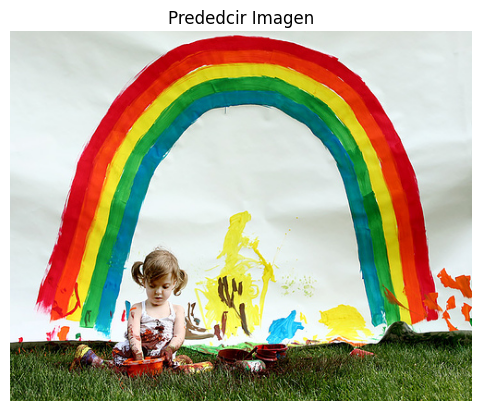


------------------ Predicted Captions ------------------
VGG16_e30_b64 Inicial: woman with pigtails is posing in front of white and two little girl in pink and white top

VGG16_model_e30_b64_lr1e-03: little girl in pigtails stands in front of rainbow painting

VGG16_model_e30_b32_lr5e-05: man wearing pink shirt and jeans is working on wooden cabin

VGG16_model_e20_b64_lr5e-05: girl in rainbow rainbow in rainbow rainbow rainbow rainbow



In [9]:

show_prediction(
    image_name="1002674143_1b742ab4b8.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images"
)


------------------ Actual Captions ------------------
startseq man in hat with long sleeves and long pants stands overlooking city endseq
startseq man stands on cliff overlooking city endseq
startseq man with backpack and hat is standing by high cliff where you can see for miles endseq
startseq hiker standing on top of rock overlooking town endseq
startseq the man wearing backpack and hat stands on ledge overlooking city endseq


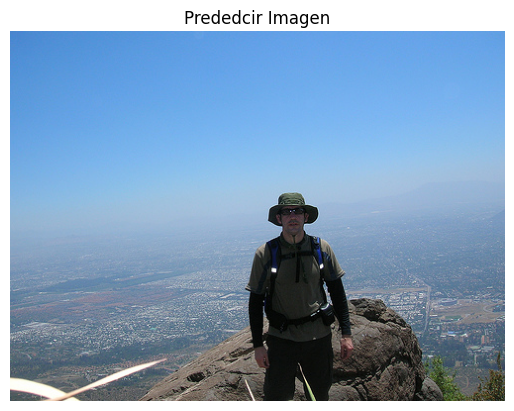


------------------ Predicted Captions ------------------
VGG16_e30_b64 Inicial: man is hiking up hill at sunset

VGG16_model_e30_b64_lr1e-03: man picking on rope on the snow

VGG16_model_e30_b32_lr5e-05: man in red jacket is climbing up the side of the rock face

VGG16_model_e20_b64_lr5e-05: man men in mountain



In [10]:


show_prediction(
    image_name="2089555297_95cf001fa7.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images"
)


------------------ Actual Captions ------------------
startseq male hiker wearing green jacket is posing next to large glacier endseq
startseq man with camera and an ice structure behind him endseq
startseq man with camera crouching on ice endseq
startseq man with camera kneels in front of giant hill of snow endseq
startseq the mountain climber prepares to take photo endseq


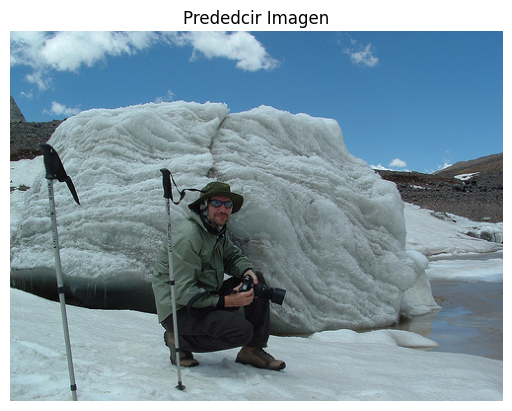


------------------ Predicted Captions ------------------
VGG16_e30_b64 Inicial: man is walking from one and two backpack in the background

VGG16_model_e30_b64_lr1e-03: man in yellow is on the rope next to the rope

VGG16_model_e30_b32_lr5e-05: man in red jacket is hiking up canyon

VGG16_model_e20_b64_lr5e-05: man in line line on the line



In [11]:
show_prediction(
    image_name="2097420505_439f63c863.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images"
)

In [56]:
descriptions

{'1000268201_693b08cb0e': ['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
  'startseq girl going into wooden building endseq',
  'startseq little girl climbing into wooden playhouse endseq',
  'startseq little girl climbing the stairs to her playhouse endseq',
  'startseq little girl in pink dress going into wooden cabin endseq'],
 '1001773457_577c3a7d70': ['startseq black dog and spotted dog are fighting endseq',
  'startseq black dog and tricolored dog playing with each other on the road endseq',
  'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
  'startseq two dogs of different breeds looking at each other on the road endseq',
  'startseq two dogs on pavement moving toward each other endseq'],
 '1002674143_1b742ab4b8': ['startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq',
  'startseq little girl is sitting in front of large painted rainbow endse

# Modelos 2

In [118]:
import pickle

with open("features.pkl", "rb") as f:
    features_vgg = pickle.load(f)

with open("features_ResNet50.pkl", "rb") as f:
    features_resnet = pickle.load(f)

with open("features_InceptionV3.pkl", "rb") as f:
    features_inception = pickle.load(f)

features_list = [features_vgg, features_resnet, features_inception]


In [122]:
def show_prediction_otros(image_name, models, model_names, tokenizer, features_list, descriptions, max_length, base_dir="Images"):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, image_name)
    image = Image.open(img_path)

    print("\n------------------ Actual Captions ------------------")
    for caption in descriptions[image_id]:
        print("•", caption)

    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicción de Imagen", fontsize=12)
    plt.show()

    print("\n------------------ Predicted Captions ------------------")
    for model, name, feats in zip(models, model_names, features_list):
        feature_vector = feats[image_id]
        expected_dim = model.input_shape[0][1]

        if feature_vector.shape[0] != expected_dim:
            print(f"[⚠️] Dimensión incorrecta para {name}. Esperada: {expected_dim}, Actual: {feature_vector.shape[0]}")
            continue

        photo = feature_vector.reshape((1, expected_dim))
        y_pred = generate_caption(model, tokenizer, photo, max_length)
        print(f"{name}: {y_pred}\n")



def show_prediction_with_probs_otros(image_name, models, model_names, tokenizer, features, descriptions, max_length, base_dir="Images", top_k=3):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(base_dir, image_name)
    image = Image.open(img_path)

    print("\n------------------ Actual Captions ------------------")
    for caption in descriptions[image_id]:
        print("•", caption)

    plt.imshow(image)
    plt.axis('off')
    plt.title("Predicción por modelos", fontsize=12)
    plt.show()

    print("\n------------------ Predicted Captions with Probabilities ------------------")
    for model, name in zip(models, model_names):
        feature_vector = features[image_id]
        expected_dim = model.input_shape[0][1]  # Detecta automáticamente input esperado

        if feature_vector.shape[0] != expected_dim:
            print(f"[⚠️] Dimensión incorrecta para {name}. Esperada: {expected_dim}, Actual: {feature_vector.shape[0]}")
            continue

        photo = feature_vector.reshape((1, expected_dim))
        caption, steps = generate_caption_with_probs(model, tokenizer, photo, max_length, top_k=top_k)
        
        print(f"\n🧠 Modelo: {name}")
        print(f"📝 Caption: {caption}\n")
        for i, step in enumerate(steps):
            print(f"Paso {i+1}: '{step['word']}'")
            for w, p in step['top_k_probs']:
                print(f"   - {w:<15} Prob: {p:.4f}")
        print("-" * 50)

In [123]:
models2 = [
    model_video,                      
    resnet50_model,          
    inception_model          
]

model_names2 = [
    "VGG16_e30_b64 Inicial",
    "ResNet50_e30_b64 Inicial",
    "InceptionV3_e30_b64 Inicial"
]




------------------ Actual Captions ------------------
• startseq child in pink dress is climbing up set of stairs in an entry way endseq
• startseq girl going into wooden building endseq
• startseq little girl climbing into wooden playhouse endseq
• startseq little girl climbing the stairs to her playhouse endseq
• startseq little girl in pink dress going into wooden cabin endseq


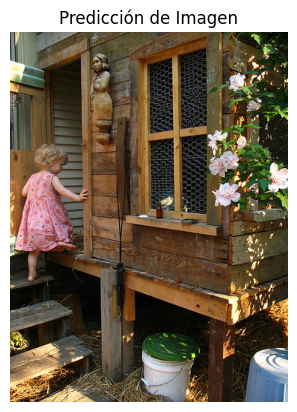


------------------ Predicted Captions ------------------
VGG16_e30_b64 Inicial: child in pink dress is standing in an entry earphones

ResNet50_e30_b64 Inicial: woman in pink dress with climbing into wooden stairs held by stairs

InceptionV3_e30_b64 Inicial: baby with gauges and orange polkadot dress is singing into microphone



In [124]:
show_prediction_otros(
    image_name="1000268201_693b08cb0e.jpg",
    models=models2,
    model_names=model_names2,
    tokenizer=tokenizer,
    features_list=features_list,   # <-- aquí pasas la lista de features
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images"
)



------------------ Actual Captions ------------------
• startseq child in pink dress is climbing up set of stairs in an entry way endseq
• startseq girl going into wooden building endseq
• startseq little girl climbing into wooden playhouse endseq
• startseq little girl climbing the stairs to her playhouse endseq
• startseq little girl in pink dress going into wooden cabin endseq


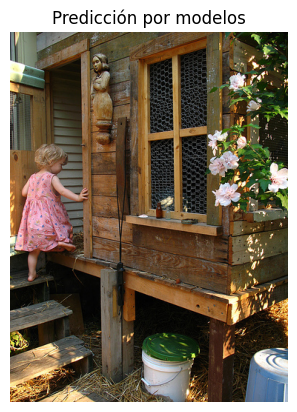


------------------ Predicted Captions with Probabilities ------------------

🧠 Modelo: VGG16_e30_b64 Inicial
📝 Caption: child in pink dress is standing in an entry earphones

Paso 1: 'child'
   - child           Prob: 0.2089
   - little          Prob: 0.1333
   - woman           Prob: 0.1294
Paso 2: 'in'
   - in              Prob: 0.6373
   - is              Prob: 0.1360
   - with            Prob: 0.0847
Paso 3: 'pink'
   - pink            Prob: 0.4627
   - yellow          Prob: 0.4401
   - boat            Prob: 0.0507
Paso 4: 'dress'
   - dress           Prob: 0.9740
   - shirt           Prob: 0.0137
   - is              Prob: 0.0027
Paso 5: 'is'
   - is              Prob: 0.5862
   - going           Prob: 0.1555
   - overlooking     Prob: 0.0783
Paso 6: 'standing'
   - standing        Prob: 0.3167
   - playing         Prob: 0.1999
   - climbing        Prob: 0.1528
Paso 7: 'in'
   - in              Prob: 0.4815
   - on              Prob: 0.3527
   - at              Prob: 0.1262
Paso 

In [125]:
show_prediction_with_probs_otros(
    image_name="1000268201_693b08cb0e.jpg",
    models=models,
    model_names=model_names,
    tokenizer=tokenizer,
    features=features,
    descriptions=descriptions,
    max_length=max_len,
    base_dir="Images",
    top_k=3  # Cambia a 5 si quieres ver top-5
)